# Рынок заведений общественного питания Москвы 



### План выполнения проекта ###

 [Шаг 1. Импорт библиотек, подготовка данных](#step1)
 
 [Шаг 2. Анализ данных](#step2)
 

* [Исследование соотношения видов объектов общественного питания по количеству.](#one)
* [Исследование соотношения сетевых и несетевых заведений по количеству.](#two)
* [Для какого вида объекта общественного питания характерно сетевое распространение?](#three)
* [Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?](#four)
* [Каково среднее количество посадочных мест для каждого вида объекта общественного питания. Какой вид предоставляет в среднем самое большое количество посадочных мест?](#five)
* [Топ-10 улиц Москвы по количеству объектов общественного питания.](#six)
* [Улицы Москвы с одним объектом общественного питания.](#seven)
* [Закономерности распределения количества посадочных мест для улиц с большим количеством объектов общественного питания.](#eight)
  
  
 [Шаг 3. Выводы](#step3)
 




## <a id="step1">Шаг 1. Импорт библиотек, подготовка данных.</a>

In [1]:
# импорт библиотек
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
 
import plotly.graph_objects as go

import numpy as np
import scipy.stats as stats

import requests
from io import BytesIO
from yaml import load, FullLoader

import time

In [2]:
rest_data = pd.read_csv("C:\\Users\\Alfa\\Downloads\\rest_data.csv")

display(rest_data.head())
rest_data.info()

id             object_name chain object_type  \
0  151635                 СМЕТАНА   нет        кафе   
1   77874                  Родник   нет        кафе   
2   24309         Кафе «Академия»   нет        кафе   
3   21894              ПИЦЦЕТОРИЯ    да        кафе   
4  119365  Кафе «Вишневая метель»   нет        кафе   

                                             address  number  
0         город Москва, улица Егора Абакумова, дом 9      48  
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35  
2          город Москва, Абельмановская улица, дом 6      95  
3            город Москва, Абрамцевская улица, дом 1      40  
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [3]:
rest_data.describe(include='all')

id object_name  chain object_type  \
count    15366.000000       15366  15366       15366   
unique            NaN       10393      2           9   
top               NaN    Столовая    нет        кафе   
freq              NaN         267  12398        6099   
mean    119720.066901         NaN    NaN         NaN   
std      73036.130732         NaN    NaN         NaN   
min        838.000000         NaN    NaN         NaN   
25%      28524.000000         NaN    NaN         NaN   
50%     144974.500000         NaN    NaN         NaN   
75%     184262.250000         NaN    NaN         NaN   
max     223439.000000         NaN    NaN         NaN   

                                       address        number  
count                                    15366  15366.000000  
unique                                    9108           NaN  
top     город Москва, Ходынский бульвар, дом 4           NaN  
freq                                        95           NaN  
mean                                       NaN     59.547182  
std                                        NaN     74.736833  
min                                        NaN      0.000000  
25%                                        NaN     12.000000  
50%                                        NaN     40.000000  
75%                                        NaN     80.000000  
max                                        NaN   1700.000000

В таблице данные о 15366 заведениях, при этом самое частое название - просто Столовая (267 столовых), большинство заведений общепита - не сетевые рестораны, причем чуть меньше половины - кафе. 

95 заведений общепита находится по одному и тому же адресу, это странно. Следует внимательнее рассмотреть все заведения, возможно это дубликаты, либо очень торговый центр, где огромное количество кафе и маленьких ресторанчиков.

Во всех заведениях присутствует большой разброс по количеству посадочных мест, при этом есть места с 0 количеством мест (возможно, это киоски или кофейни на вынос), а в среднем в каждом из мест 40-50 посадочных мест. Существует заведение, способное вместить 1700 человек. Нужно проверить.

### Замена типа данных

В столбце `chain` расположены два значения - `да` и `нет`. Для дальнейшей работы с данными лучше преобразовать тип данных на `boolean`.

In [4]:
# создадим словарь для последующей замены
bool_chain = {'да': True, 'нет': False}

# заменим с помощью словаря данные в датафрейме
rest_data=rest_data.replace(bool_chain)

In [5]:
rest_data.head()

id             object_name  chain object_type  \
0  151635                 СМЕТАНА  False        кафе   
1   77874                  Родник  False        кафе   
2   24309         Кафе «Академия»  False        кафе   
3   21894              ПИЦЦЕТОРИЯ   True        кафе   
4  119365  Кафе «Вишневая метель»  False        кафе   

                                             address  number  
0         город Москва, улица Егора Абакумова, дом 9      48  
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35  
2          город Москва, Абельмановская улица, дом 6      95  
3            город Москва, Абрамцевская улица, дом 1      40  
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50

Также необходимо заменить тип данных в столбцах с целочисленными данными с учетом минимального и максимального значений для оптимизации занимаемой памяти и скорости работы.

In [6]:
rest_data['id'] = rest_data['id'].astype(('int32'))

rest_data['number'] = rest_data['number'].astype(('int16'))

In [7]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int32
object_name    15366 non-null object
chain          15366 non-null bool
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int16
dtypes: bool(1), int16(1), int32(1), object(3)
memory usage: 465.3+ KB


### Поиск дубликатов

In [8]:
print(rest_data.duplicated().sum())

0


Полных дубликатов не имеется, посмотрим по дубликатам по идентификаторам.

In [9]:
grouped_data = rest_data.groupby(
    'id')['object_name', 'chain', 'object_type', 'address', 'number'].nunique()
display(grouped_data.sort_values(by='object_name', ascending=False))
display(grouped_data.sort_values(
    by=['object_name', 'chain', 'object_type', 'address', 'number'], ascending=False))

object_name  chain  object_type  address  number
id                                                      
838               1      1            1        1       1
166208            1      1            1        1       1
171729            1      1            1        1       1
171733            1      1            1        1       1
171738            1      1            1        1       1
...             ...    ...          ...      ...     ...
70137             1      1            1        1       1
70139             1      1            1        1       1
70144             1      1            1        1       1
70165             1      1            1        1       1
223439            1      1            1        1       1

[15366 rows x 5 columns]

object_name  chain  object_type  address  number
id                                                      
838               1      1            1        1       1
5882              1      1            1        1       1
19613             1      1            1        1       1
19618             1      1            1        1       1
19619             1      1            1        1       1
...             ...    ...          ...      ...     ...
223435            1      1            1        1       1
223436            1      1            1        1       1
223437            1      1            1        1       1
223438            1      1            1        1       1
223439            1      1            1        1       1

[15366 rows x 5 columns]

Все в порядке - дубликатов или неверных значения нет. Тем не менее, могут быть неявные дубликаты, появление которых может быть связана с неверным считыванием информации, или человеческим фактором.

#### Дубликаты в типах заведений

In [10]:
print(rest_data.object_type.value_counts())

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64


Речи о дубликатах тут быть не может - есть конкретные категории заведений, видимо, они были прописаны до заполнения данных.

#### Дубликаты в названии заведения общепита

In [11]:
print(rest_data[rest_data.chain == True]
      ['object_name'].value_counts().head(15))
print(rest_data[rest_data.chain == True]
      ['object_name'].value_counts().tail(15))

KFC                155
Шоколадница        141
Бургер Кинг        122
Макдоналдс         122
Домино'с Пицца      86
Теремок             84
Крошка Картошка     82
Милти               65
Суши Wok            61
Папа Джонс          50
Кофе с собой        44
Чайхона №1          42
Хинкальная          35
Якитория            33
Додо Пицца          31
Name: object_name, dtype: int64
Бутчер Бизон               1
ШТОЛЛЕ                     1
Кофейня «СТАРБАКС КОФЕ»    1
Ботик Петра                1
Нияма Пицца Пи             1
кафе «Му-Му»               1
Му-му                      1
Fridays KFC                1
Николай                    1
Макс Бреннер               1
Виват-Пицца                1
Бургер Клаб                1
ВОККЕР                     1
Кафе БУРГЕР КИНГ           1
ПИРОГИ ШТОЛЛЕ              1
Name: object_name, dtype: int64


In [12]:
rest_data[rest_data.object_name.str.contains('Тануки')].head()

id        object_name  chain object_type  \
18   58565             Тануки   True    ресторан   
199  27244             Тануки   True    ресторан   
208  27215      Кафе «Тануки»   True    ресторан   
327  79550             Тануки   True    ресторан   
407  27289  Ресторан «Тануки»   True    ресторан   

                                               address  number  
18   город Москва, Большая Академическая улица, дом 65     160  
199       город Москва, 3-я Владимирская улица, дом 29     100  
208       город Москва, Волгоградский проспект, дом 17     150  
327  город Москва, Дмитровское шоссе, дом 64, корпус 3     198  
407    город Москва, Каширское шоссе, дом 46, корпус 1      50

Есть заведения с идентичными названиями, есть строки, в которых названия видоизменено (например, пример с `Тануки`). Так как идентификаторы разные, то можно считать эти рестораны вписанными с некоторой ошибкой при заполнении (отсутствие единого канона записи, например). 


Проанализируем дубликаты в названиях заведения, которые не включены в единую сеть ресторанов, так как в этом случае одинаковые названия могут быть (Макдоналдс и KFC яркие тому примеры). 

In [13]:
print(rest_data[rest_data.chain == False]
      ['object_name'].value_counts().head(10))

Столовая                    267
Кафе                        236
Шаурма                      234
Пекарня                      76
Буфет                        59
СТОЛОВАЯ                     52
Школьно-базовая столовая     44
КАФЕ                         41
Выпечка                      36
Кафетерий                    35
Name: object_name, dtype: int64


Тут тоже есть дубликаты, связанные с отсутствием бренда. Так как идентификаторы разные, то данные дубликаты не повредят анализу.

То есть, дубликаты в названии мы обрабатывать не будем, так как для последующего анализа нам эти данные не пригодятся. Гораздо важнее, чтобы заведения имели лишь одно указание сетевые они или нет, а также тип заведения.

### Логические несоответствия в заполнении данных

Создадим агрегированную таблицу, где будут данные о названии заведений, у которых есть дубликаты по названию, но с разными типом объект (например, ресторан и бар), или разные типы принадлежности к сети ресторанов.

In [14]:
grouped_data = rest_data.groupby('object_name')[
    'chain', 'object_type', 'id'].nunique()
grouped_data = grouped_data[(grouped_data.chain == 2)
                            | (grouped_data.object_type > 1)]
display(grouped_data.sort_values(
    by=['chain', 'object_type'], ascending=False).head(10))
display(grouped_data.sort_values(
    by=['chain', 'object_type'], ascending=False).tail(10))
grouped_data.info()

chain  object_type   id
object_name                                   
Кофе                       2            4   16
Шоколадница                2            4  142
Кафе «Хинкальная»          2            3    9
Мята                       2            3    8
FRIDAYS                    2            2    3
Tutti frutti               2            2    2
Азбука Вкуса               2            2    9
Готовые блюда Милти        2            2    2
Кальянная Мята Lounge      2            2    4
Кафе при АЗС               2            2    5

chain  object_type  id
object_name                              
Шейк Шак               1            2   2
Шикари                 1            2   5
Школа                  1            2  14
Щербет                 1            2   2
ЭЛЬ КАФЕ               1            2   2
ЯКИТОРИЯ               1            2   5
ЯРОСЛАВСКИЙ ПОСАД      1            2   2
ЯСОН                   1            2   2
Якитория               1            2  33
Ясмин                  1            2   2

<class 'pandas.core.frame.DataFrame'>
Index: 509 entries, BB&Burgers to Ясмин
Data columns (total 3 columns):
chain          509 non-null int64
object_type    509 non-null int64
id             509 non-null int64
dtypes: int64(3)
memory usage: 15.9+ KB


In [15]:
print('Доля строк, содержащие противоречивую информацию о типе заведения и принадлежности сети, занимает:', end='')
print(round(grouped_data.id.sum()/len(rest_data)*100, 2), '%.')

Доля строк, содержащие противоречивую информацию о типе заведения и принадлежности сети, занимает:29.39 %.


Очевидно, что удалить 29 % данных было бы не очень правильно, ведь это может отразиться на анализе.

Разберем ситуацию с сетевыми ресторанами, ведь тогда несоотвествие типов может существенно исказить картину анализа, тем не менее, в основном у всех ресторанов сети с одинаковым названием, одинаковый формат заведения.

#### Обновление информации о типе заведений общепита


Рассмотрим информацию о количестве разнообразных типов объекта у заведений в сетевом формате с одинаковым названием.

In [16]:
chain_objects = rest_data[rest_data.chain == True].groupby('object_name')[
    'object_type'].nunique()
chain_objects.sort_values(ascending=False).head(10)

object_name
Милти          6
Суши Wok       5
Теремок        5
Папа Джонс     5
Бургер Кинг    5
Пицца Паоло    5
ТЕРЕМОК        5
Суши Сет       4
МИЛТИ          4
БУРГЕР КИНГ    4
Name: object_type, dtype: int64

In [17]:
rest_data[rest_data.object_name == 'Милти']

id object_name  chain                        object_type  \
9209   162189       Милти   True          магазин (отдел кулинарии)   
9953   171020       Милти   True          магазин (отдел кулинарии)   
11189  177235       Милти   True                          кафетерий   
12112  190124       Милти   True          магазин (отдел кулинарии)   
12113  189637       Милти   True          магазин (отдел кулинарии)   
...       ...         ...    ...                                ...   
15327  210815       Милти   True  предприятие быстрого обслуживания   
15328  211247       Милти   True          магазин (отдел кулинарии)   
15331  211208       Милти   True                               кафе   
15337  208477       Милти   True  предприятие быстрого обслуживания   
15338  211201       Милти   True          магазин (отдел кулинарии)   

                                                 address  number  
9209    город Москва, Головинское шоссе, дом 5, корпус 1       0  
9953   город Москва, улица Народного Ополчения, дом 3...       4  
11189  город Москва, Большая Черкизовская улица, дом 125       0  
12112   город Москва, Живописная улица, дом 12, корпус 1       4  
12113  город Москва, Новодмитровская улица, дом 2, ко...       6  
...                                                  ...     ...  
15327  город Москва, город Московский, улица Хабарова...       0  
15328          город Москва, Святоозерская улица, дом 1А       0  
15331  город Москва, Дубининская улица, дом 41, строе...       0  
15337       город Москва, 3-й Крутицкий переулок, дом 18       0  
15338          город Москва, Новослободская улица, дом 4       0  

[65 rows x 6 columns]

Примем за тип заведения в сетевых заведениях общепита первое вхождение, это вероятнее всего, верный тип. Скорее, произошла некая ошибка при заполнении данных.

Создадим список названий заведений и первым вхождением типа заведения.

In [18]:
# создаем агрегированную таблицу с первых вхождением по типу заведения для сетей
chain_types = rest_data[rest_data.chain == True].groupby('object_name')[
    'object_type'].first()

print(chain_types.head())

# сохраняем список названий сетевых заведений для последующей итерации по столбцу с названиями
chains = chain_types.index.values

object_name
Beverly Hills Diner    ресторан
Bierloga                   кафе
Black & White              кафе
Bocconcino             ресторан
BooBo                  ресторан
Name: object_type, dtype: object


In [19]:
def type_of_object(data):
    # функция итерирует название сетевых заведений и возвращает
    # значение первого вхождения типа заведения
    name = data.object_name
    object_type = data.object_type
    chain = data.chain
    if (name in chains) & (chain == True):
        type = chain_types.loc[name]
    else:
        type = object_type
    return type


# применяем функцию к датафрейму и создаем новый столбец с обновленными данными
rest_data['object_type_update'] = rest_data.apply(type_of_object, axis=1)

In [20]:
rest_data.head(15)

id               object_name  chain object_type  \
0   151635                   СМЕТАНА  False        кафе   
1    77874                    Родник  False        кафе   
2    24309           Кафе «Академия»  False        кафе   
3    21894                ПИЦЦЕТОРИЯ   True        кафе   
4   119365    Кафе «Вишневая метель»  False        кафе   
5    27429  СТОЛ. ПРИ ГОУ СОШ № 1051  False    столовая   
6   148815                  Брусника   True        кафе   
7    20957               Буфет МТУСИ  False    столовая   
8    20958               КПФ СЕМЬЯ-1  False    столовая   
9    28858            Столовая МТУСИ  False    столовая   
10  148595                Пекарня 24  False  закусочная   
11   23394                   Гогиели  False        кафе   
12   28582                 ШКОЛА 735  False    столовая   
13   22579                Алло Пицца   True        кафе   
14   23670             Гимназия 1542  False    столовая   

                                              address  number  \
0          город Москва, улица Егора Абакумова, дом 9      48   
1   город Москва, улица Талалихина, дом 2/1, корпус 1      35   
2           город Москва, Абельмановская улица, дом 6      95   
3             город Москва, Абрамцевская улица, дом 1      40   
4   город Москва, Абрамцевская улица, дом 9, корпус 1      50   
5   город Москва, Абрамцевская улица, дом 15, корп...     240   
6       город Москва, переулок Сивцев Вражек, дом 6/2      10   
7   город Москва, Авиамоторная улица, дом 8, строе...      90   
8   город Москва, Авиамоторная улица, дом 8, строе...     150   
9   город Москва, Авиамоторная улица, дом 8, строе...     120   
10           город Москва, Авиамоторная улица, дом 47       5   
11         город Москва, Авиамоторная улица, дом 49/1      24   
12           город Москва, Авиамоторная улица, дом 51     140   
13              город Москва, улица Авиаторов, дом 14      32   
14              город Москва, улица Авиаторов, дом 16     270   

   object_type_update  
0                кафе  
1                кафе  
2                кафе  
3                кафе  
4                кафе  
5            столовая  
6                кафе  
7            столовая  
8            столовая  
9            столовая  
10         закусочная  
11               кафе  
12           столовая  
13               кафе  
14           столовая

####  Обновление информации о принадлежности к сети

Так как мы разобрались с типом заведения в сетевых заведениях, можно не учитывать заведения с одинаковым названием, но с нексколькими типами объекта в несетевых ресторанах. Такое может быть, ведь хозяин - не един.

Cоздадим агрегированную таблицу для уточнения следующего пункта логического несоотвествия данных, с указанием только одного несоотвесттвия - в нескольких и более записях с одинаковым названием фигурируют и сетевые, и несетевые рестораны.

In [21]:
grouped_data_update = rest_data.groupby(
    'object_name')['chain', 'object_type_update', 'id'].nunique()
grouped_data_update = grouped_data_update[grouped_data_update.chain == 2]
display(grouped_data_update.sort_values(
    by=['chain', 'object_type_update'], ascending=False).head(10))
display(grouped_data_update.sort_values(
    by=['chain', 'object_type_update'], ascending=False).tail(10))
grouped_data_update.info()

chain  object_type_update  id
object_name                                          
Кофе                        2                   4  16
Кафе «Хинкальная»           2                   3   9
Мята                        2                   3   8
FRIDAYS                     2                   2   3
Tutti frutti                2                   2   2
Готовые блюда Милти         2                   2   2
Кальянная Мята Lounge       2                   2   4
Кафе при АЗС                2                   2   5
Лукойл                      2                   2   3
Ресторан «Бургер Кинг»      2                   2   2

chain  object_type_update   id
object_name                                                    
Кафе «Шоколадница»                   2                   1   16
Кафе «Штолле»                        2                   1    3
Колбасофф                            2                   1    3
Кондитерская-пекарня Волконский      2                   1    3
Пицца «Паоло»                        2                   1    2
Ресторан «KFC»                       2                   1    3
Ресторан «Хинкальная»                2                   1    2
Ресторан «Якитория»                  2                   1    2
Шоколадница                          2                   1  142
Япоша                                2                   1    2

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, FRIDAYS to Япоша
Data columns (total 3 columns):
chain                 29 non-null int64
object_type_update    29 non-null int64
id                    29 non-null int64
dtypes: int64(3)
memory usage: 928.0+ bytes


In [22]:
print('Доля строк, содержащие противоречивую информацию о типе принадлежности сети, занимает:', end='')
print(round(grouped_data_update.id.sum()/len(rest_data)*100, 2), '%.')

Доля строк, содержащие противоречивую информацию о типе принадлежности сети, занимает:1.71 %.


Сформируем список с названиями заведений, имеющие 1 тип заведения и больше 2 объектов с идентичными названиями, как наиболее возможными сетевыми ресторанами.

In [23]:
names_with_probable_chain = grouped_data_update[(
    grouped_data_update.object_type_update == 1) & (grouped_data_update.id > 2)].index.values
print(names_with_probable_chain)

['Upside Down Cake' 'Азбука Вкуса' 'Азбука вкуса' 'Кафе «Subway»'
 'Кафе «Шоколадница»' 'Кафе «Штолле»' 'Колбасофф'
 'Кондитерская-пекарня Волконский' 'Ресторан «KFC»' 'Шоколадница']


In [24]:
def chain_or_not(data):
    # функция итерирует названия возможных сетевых заведения и возвращает
    # значение "да" в столбце с обновленными данными о принадлежности к сети
    name = data.object_name
    chain = data.chain
    if (name in names_with_probable_chain):
        chain_upd = True
    else:
        chain_upd = chain
    return chain_upd


# создание столбца с обновленными данными о принадлежности заведения к сети при помощи функции
rest_data['chain_update'] = rest_data.apply(chain_or_not, axis=1)

In [25]:
# проверка внесенных изменений
rest_data[rest_data.object_name.isin(names_with_probable_chain)].sample(10)

id         object_name  chain object_type  \
683     71378         Шоколадница   True        кафе   
887     21774  Кафе «Шоколадница»   True        кафе   
4265    72587         Шоколадница   True        кафе   
6583    20035         Шоколадница   True        кафе   
294     25124         Шоколадница   True        кафе   
15364  221900         Шоколадница   True        кафе   
2347    77005         Шоколадница   True        кафе   
563     22693         Шоколадница   True        кафе   
1031    21743         Шоколадница   True        кафе   
319     22635         Шоколадница   True        кафе   

                                                 address  number  \
683                  город Москва, проспект Мира, дом 29      40   
887             город Москва, улица Шаболовка, дом 30/12      48   
4265   город Москва, улица Кузнецкий Мост, дом 11, ст...      96   
6583               город Москва, Минская улица, дом 14-А      73   
294                  город Москва, улица Чаянова, дом 12      35   
15364  город Москва, поселение Московский, Киевское ш...      36   
2347   город Москва, Мясницкая улица, дом 14/2, строе...      95   
563    город Москва, Ленинградский проспект, дом 74, ...      98   
1031   город Москва, Садовая-Черногрязская улица, дом...      65   
319       город Москва, улица Большая Якиманка, дом 58/2      50   

      object_type_update  chain_update  
683                 кафе          True  
887                 кафе          True  
4265                кафе          True  
6583                кафе          True  
294                 кафе          True  
15364               кафе          True  
2347                кафе          True  
563                 кафе          True  
1031                кафе          True  
319                 кафе          True

Cоздадим агрегированную таблицу для проверки логических несоотвествий с учетом обновленных данных.

In [26]:
grouped_data_final = rest_data.groupby(
    'object_name')['chain_update', 'object_type_update', 'id'].nunique()
grouped_data_final = grouped_data_final[grouped_data_final.chain_update == 2]
display(grouped_data_final.sort_values(
    by=['chain_update', 'object_type_update'], ascending=False).head(10))
display(grouped_data_final.sort_values(
    by=['chain_update', 'object_type_update'], ascending=False).tail(10))
grouped_data_final.info()

chain_update  object_type_update  id
object_name                                                 
Кофе                               2                   4  16
Кафе «Хинкальная»                  2                   3   9
Мята                               2                   3   8
FRIDAYS                            2                   2   3
Tutti frutti                       2                   2   2
Готовые блюда Милти                2                   2   2
Кальянная Мята Lounge              2                   2   4
Кафе при АЗС                       2                   2   5
Лукойл                             2                   2   3
Ресторан «Бургер Кинг»             2                   2   2

chain_update  object_type_update  id
object_name                                                 
Ресторан «Бургер Кинг»             2                   2   2
Темпл Бар                          2                   2   2
Теремок-Инвест                     2                   2   2
Goodman Гудман                     2                   1   2
UPSIDE DOWN CAKE                   2                   1   2
Виктория                           2                   1   2
Пицца «Паоло»                      2                   1   2
Ресторан «Хинкальная»              2                   1   2
Ресторан «Якитория»                2                   1   2
Япоша                              2                   1   2

<class 'pandas.core.frame.DataFrame'>
Index: 19 entries, FRIDAYS to Япоша
Data columns (total 3 columns):
chain_update          19 non-null int64
object_type_update    19 non-null int64
id                    19 non-null int64
dtypes: int64(3)
memory usage: 608.0+ bytes


In [27]:
print('Доля строк, содержащие противоречивую информацию, занимает:', end='')
print(round(grouped_data_final.id.sum()/len(rest_data)*100, 2), '%.')

Доля строк, содержащие противоречивую информацию, занимает:0.47 %.


Всего 19 строк названий заведений, общее число которых составляет менее 1 % данных, можно исключить данные из общей таблицы.

Создадим копию датафрейма с обновленными данными и без учета тех заведений, которые несут противоречивую информацию.

In [28]:
rest_data_allright = rest_data[~rest_data.object_name.isin(grouped_data_final.index.values)][[
    'id', 'object_name', 'chain_update', 'object_type_update', 'address', 'number', ]].copy(deep=True)

rest_data_allright.head(10)

id               object_name  chain_update object_type_update  \
0  151635                   СМЕТАНА         False               кафе   
1   77874                    Родник         False               кафе   
2   24309           Кафе «Академия»         False               кафе   
3   21894                ПИЦЦЕТОРИЯ          True               кафе   
4  119365    Кафе «Вишневая метель»         False               кафе   
5   27429  СТОЛ. ПРИ ГОУ СОШ № 1051         False           столовая   
6  148815                  Брусника          True               кафе   
7   20957               Буфет МТУСИ         False           столовая   
8   20958               КПФ СЕМЬЯ-1         False           столовая   
9   28858            Столовая МТУСИ         False           столовая   

                                             address  number  
0         город Москва, улица Егора Абакумова, дом 9      48  
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35  
2          город Москва, Абельмановская улица, дом 6      95  
3            город Москва, Абрамцевская улица, дом 1      40  
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50  
5  город Москва, Абрамцевская улица, дом 15, корп...     240  
6      город Москва, переулок Сивцев Вражек, дом 6/2      10  
7  город Москва, Авиамоторная улица, дом 8, строе...      90  
8  город Москва, Авиамоторная улица, дом 8, строе...     150  
9  город Москва, Авиамоторная улица, дом 8, строе...     120

In [29]:
rest_data_allright.info()
display(rest_data_allright.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15294 entries, 0 to 15365
Data columns (total 6 columns):
id                    15294 non-null int32
object_name           15294 non-null object
chain_update          15294 non-null bool
object_type_update    15294 non-null object
address               15294 non-null object
number                15294 non-null int16
dtypes: bool(1), int16(1), int32(1), object(3)
memory usage: 582.5+ KB


id object_name chain_update object_type_update  \
count    15294.000000       15294        15294              15294   
unique            NaN       10374            2                  9   
top               NaN    Столовая        False               кафе   
freq              NaN         267        12328               6052   
mean    119547.530012         NaN          NaN                NaN   
std      73086.790395         NaN          NaN                NaN   
min       5882.000000         NaN          NaN                NaN   
25%      28487.750000         NaN          NaN                NaN   
50%     144812.500000         NaN          NaN                NaN   
75%     184176.250000         NaN          NaN                NaN   
max     223439.000000         NaN          NaN                NaN   

                                       address        number  
count                                    15294  15294.000000  
unique                                    9083           NaN  
top     город Москва, Ходынский бульвар, дом 4           NaN  
freq                                        92           NaN  
mean                                       NaN     59.672355  
std                                        NaN     74.813813  
min                                        NaN      0.000000  
25%                                        NaN     12.000000  
50%                                        NaN     40.000000  
75%                                        NaN     80.000000  
max                                        NaN   1700.000000

### Добавление информации о местоположении ресторанов

Для дальнейшего исследования рынка общественного питания необходимы более детальные сведения о ресторанах - а именно, район Москвы, в котором находится ресторан, а также улицу. Для начала выведем в отдельный стобец улицу из полного адреса заведения.

#### Добавление информации о районе в таблицу


Для добавления информации о районе, используем API Яндекс.Карт. Готовую таблицу выгружаем далее:

In [30]:
  
spreadsheet_id = '1VeP2U-fMkUTLVuQcRPVsuD8QhahbHTU3RKKKR3khQ3Y'
file_addresses_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r_addresses = requests.get(file_addresses_name)
rest_data_upd = pd.read_csv(BytesIO(r_addresses.content))
rest_data_upd.head() 



id             object_name  chain_update object_type_update  \
0  151635                 СМЕТАНА         False               кафе   
1   77874                  Родник         False               кафе   
2   24309         Кафе «Академия»         False               кафе   
3   21894              ПИЦЦЕТОРИЯ          True               кафе   
4  119365  Кафе «Вишневая метель»         False               кафе   

                                             address  number  \
0         город Москва, улица Егора Абакумова, дом 9      48   
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35   
2          город Москва, Абельмановская улица, дом 6      95   
3            город Москва, Абрамцевская улица, дом 1      40   
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50   

           coordinates           district  
0  37.714474 55.879005  Ярославский район  
1  37.673295 55.738307    Таганский район  
2  37.669576 55.735571    Таганский район  
3  37.573007 55.892713    район Лианозово  
4  37.572279 55.904074    район Лианозово

In [31]:
rest_data_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15294 entries, 0 to 15293
Data columns (total 8 columns):
id                    15294 non-null int64
object_name           15294 non-null object
chain_update          15294 non-null bool
object_type_update    15294 non-null object
address               15294 non-null object
number                15294 non-null int64
coordinates           15261 non-null object
district              14642 non-null object
dtypes: bool(1), int64(2), object(5)
memory usage: 851.5+ KB


Рассмотрим пропущенные значения.

#### Выделение в отдельный столбец информацию об улице из столбца address .

In [32]:
streets = ['переулок', 'улица', 'шоссе', 'бульвар', 'проспект', 'набережная', 'проезд', 'тупик', 'площадь']

In [33]:
def find_street(address):
    for n in range(len(address.split(', '))):
        for street in streets:
            if street in address.split(', ')[n]:
                return address.split(', ')[n]
            else: 
                continue

# создадим столбец street, который будет содержать улицу, на которой расположено заведение    
rest_data_upd['street'] = rest_data_upd['address'].apply(find_street)

In [34]:
rest_data_upd.head()

id             object_name  chain_update object_type_update  \
0  151635                 СМЕТАНА         False               кафе   
1   77874                  Родник         False               кафе   
2   24309         Кафе «Академия»         False               кафе   
3   21894              ПИЦЦЕТОРИЯ          True               кафе   
4  119365  Кафе «Вишневая метель»         False               кафе   

                                             address  number  \
0         город Москва, улица Егора Абакумова, дом 9      48   
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35   
2          город Москва, Абельмановская улица, дом 6      95   
3            город Москва, Абрамцевская улица, дом 1      40   
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50   

           coordinates           district                 street  
0  37.714474 55.879005  Ярославский район  улица Егора Абакумова  
1  37.673295 55.738307    Таганский район       улица Талалихина  
2  37.669576 55.735571    Таганский район   Абельмановская улица  
3  37.573007 55.892713    район Лианозово     Абрамцевская улица  
4  37.572279 55.904074    район Лианозово     Абрамцевская улица

In [35]:
# уберем пробелы в начале некоторых названий в столбце с улице
rest_data_upd['street'] = rest_data_upd['street'].str.lstrip()

In [36]:
rest_data_upd.head(10)

id               object_name  chain_update object_type_update  \
0  151635                   СМЕТАНА         False               кафе   
1   77874                    Родник         False               кафе   
2   24309           Кафе «Академия»         False               кафе   
3   21894                ПИЦЦЕТОРИЯ          True               кафе   
4  119365    Кафе «Вишневая метель»         False               кафе   
5   27429  СТОЛ. ПРИ ГОУ СОШ № 1051         False           столовая   
6  148815                  Брусника          True               кафе   
7   20957               Буфет МТУСИ         False           столовая   
8   20958               КПФ СЕМЬЯ-1         False           столовая   
9   28858            Столовая МТУСИ         False           столовая   

                                             address  number  \
0         город Москва, улица Егора Абакумова, дом 9      48   
1  город Москва, улица Талалихина, дом 2/1, корпус 1      35   
2          город Москва, Абельмановская улица, дом 6      95   
3            город Москва, Абрамцевская улица, дом 1      40   
4  город Москва, Абрамцевская улица, дом 9, корпус 1      50   
5  город Москва, Абрамцевская улица, дом 15, корп...     240   
6      город Москва, переулок Сивцев Вражек, дом 6/2      10   
7  город Москва, Авиамоторная улица, дом 8, строе...      90   
8  город Москва, Авиамоторная улица, дом 8, строе...     150   
9  город Москва, Авиамоторная улица, дом 8, строе...     120   

           coordinates           district                  street  
0  37.714474 55.879005  Ярославский район   улица Егора Абакумова  
1  37.673295 55.738307    Таганский район        улица Талалихина  
2  37.669576 55.735571    Таганский район    Абельмановская улица  
3  37.573007 55.892713    район Лианозово      Абрамцевская улица  
4  37.572279 55.904074    район Лианозово      Абрамцевская улица  
5  37.571525 55.906744    район Лианозово      Абрамцевская улица  
6  37.598043 55.747388        район Арбат  переулок Сивцев Вражек  
7  37.715471 55.754882    район Лефортово      Авиамоторная улица  
8  37.715471 55.754882    район Лефортово      Авиамоторная улица  
9  37.715471 55.754882    район Лефортово      Авиамоторная улица

### Где в Москве располагается место с самым большим количеством заведений общепита?

In [37]:
rest_data_upd[rest_data_upd['address'] ==
              'город Москва, Ходынский бульвар, дом 4'].sort_values(by='number')

id                    object_name  chain_update object_type_update  \
14837  215307                      Franklins         False               кафе   
14860  222977                   Fruity yummy         False               кафе   
14859  222973                      Fruit Lab         False               кафе   
14858  222963                  Cream Station         False               кафе   
14857  222959                        Да, еда         False               кафе   
...       ...                            ...           ...                ...   
14821  215416                         Ереван         False           ресторан   
15066  215430                 Порто Мальтезе          True           ресторан   
14832  215439                         Шикари         False           ресторан   
14836  215305  Forte Bello, Zafferano, Edoko         False           ресторан   
11756   94667                   Хмели-Сунели         False           ресторан   

                                      address  number         coordinates  \
14837  город Москва, Ходынский бульвар, дом 4       0  37.53128 55.790231   
14860  город Москва, Ходынский бульвар, дом 4       0  37.53128 55.790231   
14859  город Москва, Ходынский бульвар, дом 4       0  37.53128 55.790231   
14858  город Москва, Ходынский бульвар, дом 4       0  37.53128 55.790231   
14857  город Москва, Ходынский бульвар, дом 4       0  37.53128 55.790231   
...                                       ...     ...                 ...   
14821  город Москва, Ходынский бульвар, дом 4      54  37.53128 55.790231   
15066  город Москва, Ходынский бульвар, дом 4      56  37.53128 55.790231   
14832  город Москва, Ходынский бульвар, дом 4      64  37.53128 55.790231   
14836  город Москва, Ходынский бульвар, дом 4      90  37.53128 55.790231   
11756  город Москва, Ходынский бульвар, дом 4     100  37.53128 55.790231   

                district             street  
14837  Хорошёвский район  Ходынский бульвар  
14860  Хорошёвский район  Ходынский бульвар  
14859  Хорошёвский район  Ходынский бульвар  
14858  Хорошёвский район  Ходынский бульвар  
14857  Хорошёвский район  Ходынский бульвар  
...                  ...                ...  
14821  Хорошёвский район  Ходынский бульвар  
15066  Хорошёвский район  Ходынский бульвар  
14832  Хорошёвский район  Ходынский бульвар  
14836  Хорошёвский район  Ходынский бульвар  
11756  Хорошёвский район  Ходынский бульвар  

[92 rows x 9 columns]

Text(0, 0.5, 'Количество заведений общепита')

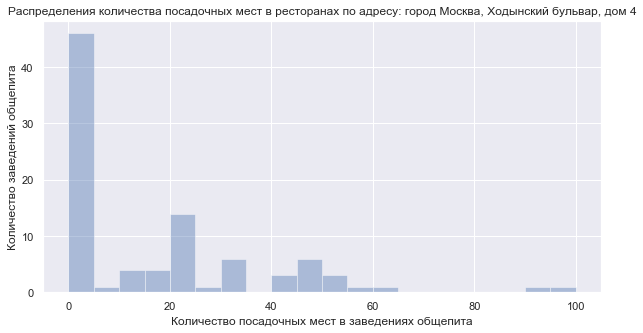

In [38]:
sns.set(style='darkgrid')

plt.figure(figsize=(10,5))
sns.distplot(rest_data_upd[rest_data_upd['address'] ==
                           'город Москва, Ходынский бульвар, дом 4']['number'], kde=False, bins=20)
plt.title('Распределения количества посадочных мест в ресторанах по адресу: город Москва, Ходынский бульвар, дом 4')
plt.xlabel('Количество посадочных мест в заведениях общепита')
plt.ylabel('Количество заведений общепита')

По данному адресу располагается огромный Авиа парк, где действительно много где можно перекусить или отобедать. все дело в его огромной площади - 400 000 кв.м. общей площади и 230 000 кв.м. торговой, что делает Авиа парк крупнейший торговым центром в Европе.

При этом больше всего (чуть меньше половины) там располагается так называемые "островки", где нет посадочных мест, можно купить с собой кофе, сок, мороженое или что-то подобное и пойти дальше по магазинам.

### Самый большой ресторан?

In [39]:
rest_data_upd[rest_data_upd['number'] == rest_data_upd['number'].max()]

id           object_name  chain_update object_type_update  \
12663  199696  Arena by Soho Family         False                бар   

                                                 address  number  \
12663  город Москва, Кутузовский проспект, дом 36, ст...    1700   

               coordinates            district                street  
12663  37.526717 55.741987  район Дорогомилово  Кутузовский проспект

Итак, Arena by Soho Family - это бар, а также крупная концентрая площадка, в которой можно и выпить, и поесть, и послушать любимых исполнителей (общая вместимость 6000 человек)

## <a id="step2">Шаг 2. Анализ данных.</a>

### <a id="one">Исследование соотношения видов объектов общественного питания по количеству.</a>


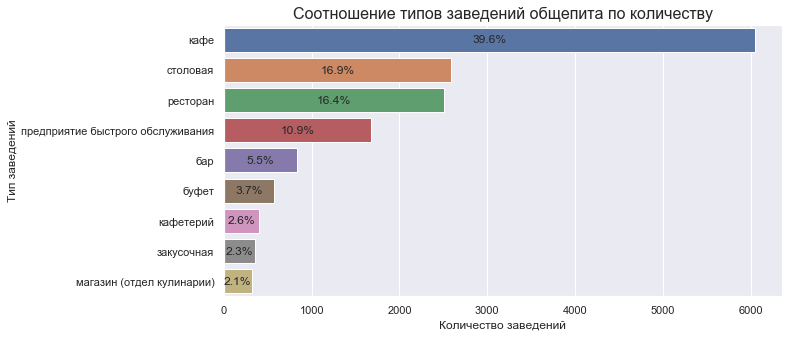

In [40]:
plt.figure(figsize=(10, 5));
ax=sns.countplot(y='object_type_update', data=rest_data_upd,
                   order=rest_data_upd['object_type_update'].value_counts().index);
plt.title('Соотношение типов заведений общепита по количеству', fontdict={'fontsize': 16});
plt.xlabel('Количество заведений');
plt.ylabel('Тип заведений');
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate('{:.1f}%'.format(100.*width/len(rest_data_upd)), xy=(left+width/2, bottom+height/2), 
                ha='center', va='center')
#plt.savefig('1.png', bbox_inches='tight');
plt.show()

Несомненно, лидируют кафе, они более демократичны для посещения по ценам, по обстановке и по требованиям.

На втором месте, немного обогнав рестораны - столовые. Столовые при госучреждениях (школы, институты, заводы), а также просто в черте города - это бюджетно.

На третьем месте - рестораны. Всегда приятно сходить в такие места, но не так часто - может ударить по кошельку.

Фастфуд также популярен, но более вреден. 

Баров достаточно, но видимо, уменьшает отток клиентов, если нет полного меню. К тому же, гости, которые просто пьют алкоголь, но забывают про закуски, могут стать тяжелым грузом для заведения.

Кафетерии, закусочные - пережитки советского прошлого, а магазиинов в отделе кулинарии не так много из-за того, что их достаточно всего 1 на один большой супермаркет, вед иначе он не будет окупаться.

### <a id="two">Исследование соотношения сетевых и несетевых заведений по количеству.</a>

In [41]:

labels = ['Несетевые заведения', 'Сетевые заведения']
values = rest_data_upd['chain_update'].value_counts()
 
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(title_text='Соотношение сетевых и несетевых заведений по количеству', font=dict(size=16))
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()
# fig.write_image('2.png')
plt.show()

Отчетливо видно, что большая часть заведений не относится к сети. Лишь 19 процентов из 100 - сетевые рестораны. 

Сетевые рестораны требуют больших вложений, как материальных, так и физических - необходимо нанять слаженную команду, отладить все процессы до автоматизма. Меньшими потерями, скорее всего, отделываются только заведения-франшизы.

### <a id="three">Для какого вида объекта общественного питания характерно сетевое распространение?</a>

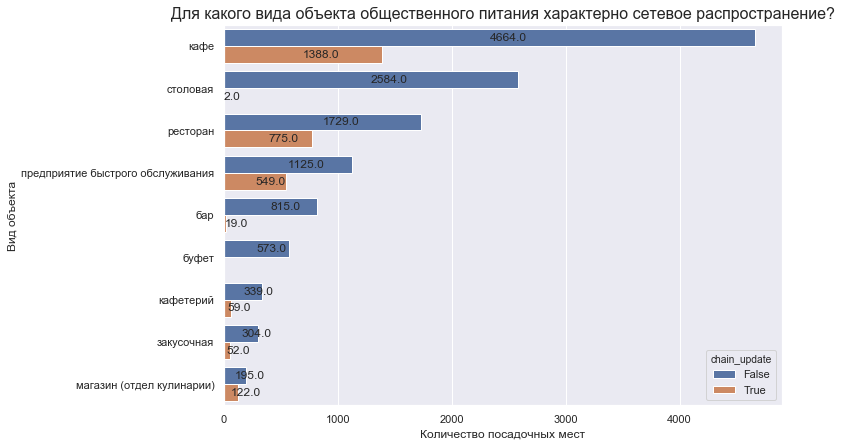

In [42]:
plt.figure(figsize=(10, 7))
ax = sns.countplot(y='object_type_update', data=rest_data_upd, hue='chain_update',
                   order=rest_data_upd['object_type_update'].value_counts().index)
plt.title('Для какого вида объекта общественного питания характерно сетевое распространение?', fontdict={'fontsize': 16})
plt.xlabel('Количество посадочных мест')
plt.ylabel('Вид объекта')
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(width), xy=(left+width/2, bottom+height/2), 
                ha='left', va='center')
# plt.savefig('3.png', bbox_inches='tight');
plt.show()

Сетевое распространение характерно для кафе, ресторанов и предприятия быстрого обслуживания. Очень редки сети в магазинах(отдел кулинарии), кафетериях и закусочных, что обуславливается низкой распространенностью таких типов объектов общепита.

Совсем не типично для сетей иметь столовые, буфеты и бары.

Столовые, хоть и очень популярные, но очень много денег они не приносят, видимо.

Сети вкладываются в заочно прибыльные вещи, у них все рассчитано, значит и ориентироваться можно на первые три типа - кафе, рестораны и предприятия быстрого обслуживания. Скорее всего, они приносят больше денег.

### <a id="four">Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?</a>

Text(0.5, 0, 'Количество посадочных мест')

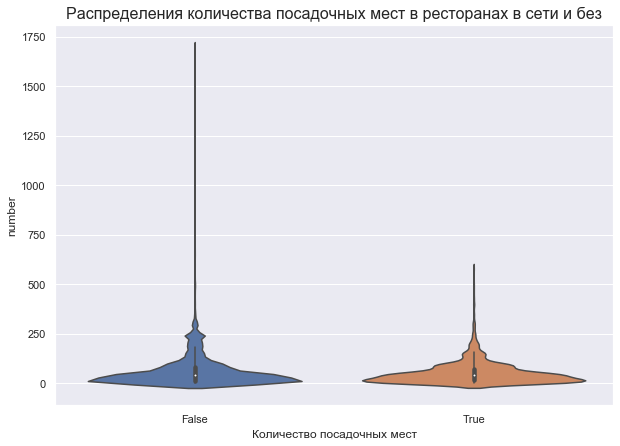

In [43]:
plt.figure(figsize=(10,7))
sns.violinplot(x='chain_update', y='number', data=rest_data_upd)
plt.title('Распределения количества посадочных мест в ресторанах в сети и без', fontdict={'fontsize': 16})
plt.xlabel('Количество посадочных мест')


Распределение похоже, медианы почти совпадают, тем не менее, можно увидеть, что владельцы сетевых ресторанов совсем не открывают заведения с количеством посадочныз мест более 600-650.

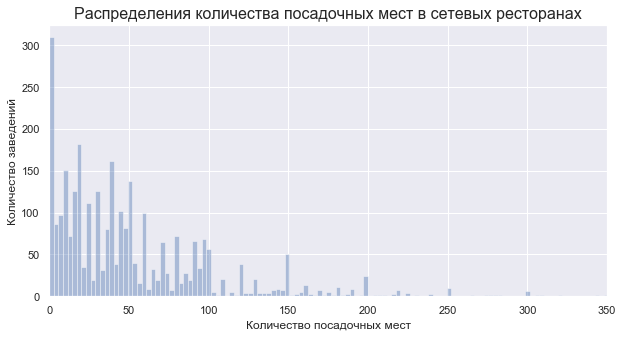

In [44]:
plt.figure(figsize=(10,5))
sns.distplot(rest_data_upd[rest_data_upd.chain_update==True]['number'], kde=False, bins=200)
plt.title('Распределения количества посадочных мест в сетевых ресторанах', fontdict={'fontsize': 16})
plt.xlabel('Количество посадочных мест')
plt.ylabel('Количество заведений')
plt.xlim(0,350)
# plt.savefig('4.png', bbox_inches='tight');
plt.show()

Очень много сетевых ресторанов с количеством посадочных мест до 100, далее - их количество резко сокращается.

In [45]:
print(rest_data_upd[rest_data_upd.chain_update==True]['number'].describe())

count    2966.000000
mean       52.792987
std        56.900051
min         0.000000
25%        15.000000
50%        40.000000
75%        72.000000
max       580.000000
Name: number, dtype: float64


Text(0.5, 0, 'Количество посадочных мест')

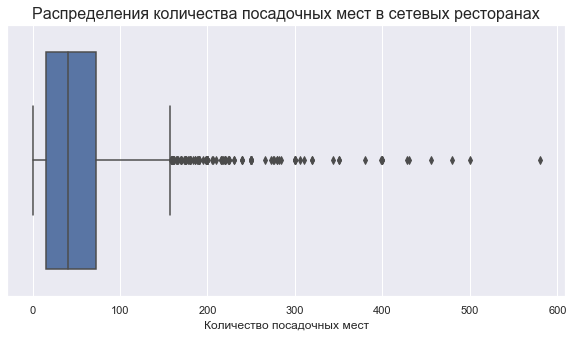

In [46]:
plt.figure(figsize=(10,5))
sns.boxplot(rest_data_upd[rest_data_upd.chain_update==True]['number'])
plt.title('Распределения количества посадочных мест в сетевых ресторанах', fontdict={'fontsize': 16})
plt.xlabel('Количество посадочных мест')


Для сетевых ресторанов типичны сразу две характеристики: много заведений с небольшим количеством посадочных мест (половина заведений имеет до 40 посадочных мест), а также небольшое количество объектов общепита с большой вместимостью. Больше 150 мест - это, скорее, исключение из правил.

Оно и понятно: небольшими заведениями проще управлять, для больших нужно очень много ресурсов и часто расходы не окупаются.

### <a id="five">Каково среднее количество посадочных мест для каждого вида объекта общественного питания. Какой вид предоставляет в среднем самое большое количество посадочных мест? </a>

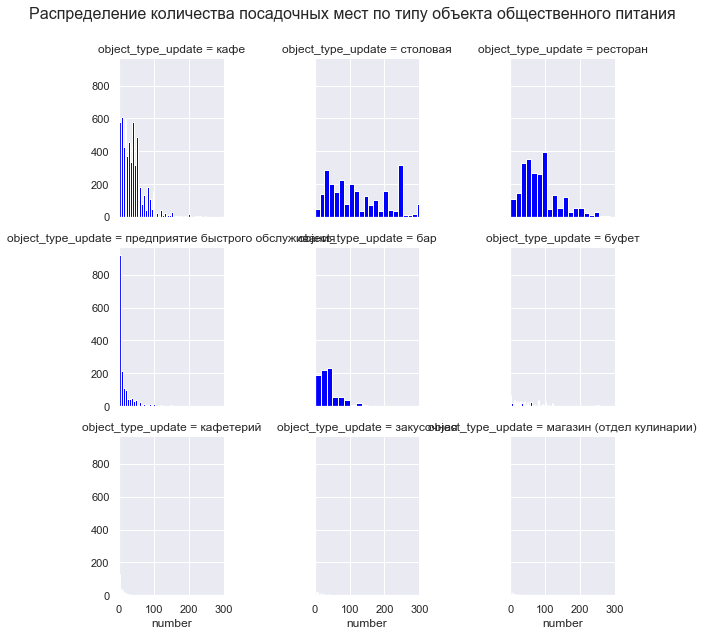

In [47]:
g = sns.FacetGrid(rest_data_upd, col='object_type_update', col_wrap=3, margin_titles=True,
                  col_order=rest_data_upd['object_type_update'].value_counts().index)
g = g.map(plt.hist, 'number', bins=100, color='blue')
g.set(xlim=(0, 300))
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle('Распределение количества посадочных мест по типу объекта общественного питания', fontsize=16) 
g.figsize=(20,100)


Можно увидеть, что распределение количества посадочных мест в типах заведения `кафе` влияет на общее распределение, как самое популярное. То есть, много заведений с малым количеством посадочных мест и мало заведений с большей вместимостью.

Чуть равномернее распределено количество посадочных мест в столовых - то возрастая, то убывая. причем количество 250 посадочных мест - самое популярное для столовых. Возможно это заведения при заводах, университетах.

Вместимость во многих ресторанах в пределах 50-100 посадочных иест, далее - идет на убыль.

КОнечно, в предприятиях быстрого обслуживания - киоски, фастфуд - типично 0-20 посадочных мест. Они здорово экономят на обслуживаюшем персонале и аренде.

Бары - это заведения в основном до 50 посадочных мест. Очень редко - больше 100.

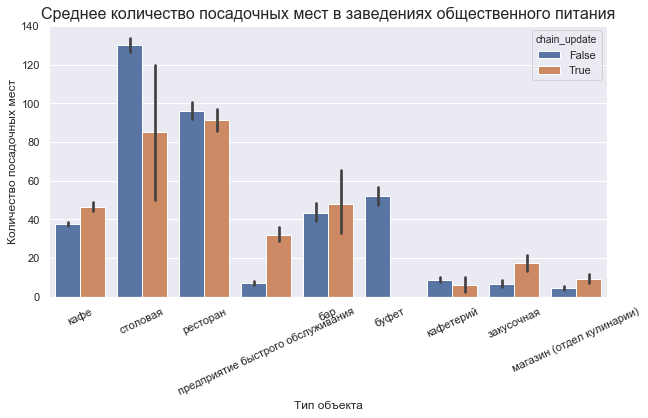

In [48]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='object_type_update', y='number', hue='chain_update',
                 data=rest_data_upd, order=rest_data_upd['object_type_update'].value_counts().index)
plt.xticks(rotation=25)
plt.title('Среднее количество посадочных мест в заведениях общественного питания', fontdict = {'fontsize' : 16})
plt.xlabel('Тип объекта')
plt.ylabel('Количество посадочных мест')
# plt.savefig('5.png', bbox_inches='tight');
plt.show()

Среднее количество посадочных мест в самых распространенных заведениях - кафе - около 40-50, несильно отличается у сетевых и несетевых заведений.

Также видно, как сильно выбивается вперед средняя вместиммость в столовых - 130 человек, при этом стоит заметить, что столовые нетипичны для сетевого распространения, но те, что есть - имеют не более 90 посадочных мест в среднем.

В ресторанах средняя вместимость несильно отличается от сетевой принадлежности - 80-90 мест.

При этом сетевые предприятия быстрого обслуживания могут себе позволить гораздо больше посадочных мест вследствии широкой популярности сети (КФС, Макдональдс и т.д.) - в седнем чуть менее 40 посадочных места. А несетевые стараются вместить не более 10 человек.

Буфеты достаточно просторные - в среднем одновременно их могут посетить около 50 человек, однако это типично для несетевых заведения, скорее в школах или театрах.

Кафетериии, закусочные и магазины - отделы кулинарии е могут похвастаться большим количеством посадочных мест - в среднем до 10. Однако сетевые закусочные вмещают чуть больще - в среднем до 20 (опять таки, в силу известности).

В среднем, самое большое среднее количество посадочных мест показывают несетевые столовые - 130 человек. Это много, но это необходимость, так как основная масса посетителей приходит во время обеда и одновременно.

### <a id="six">Топ-10 улиц Москвы по количеству объектов общественного питания. </a> 

Проанализируем топ самых популярных улиц по количеству заведений общепита.

In [49]:
# создаем агрегированную таблицу с количеством заведений по улице
rest_data_streets = rest_data_upd.groupby('street')['id'].count().sort_values(ascending=False)

display(rest_data_streets.head(10))

# сохраняем список топ 10 улиц
top10_streets = rest_data_streets.index[0:10].values
print(top10_streets)

street
проспект Мира             203
Профсоюзная улица         181
Ленинградский проспект    173
Пресненская набережная    165
Варшавское шоссе          165
Ленинский проспект        147
проспект Вернадского      132
Кутузовский проспект      114
Каширское шоссе           111
Кировоградская улица      108
Name: id, dtype: int64

['проспект Мира' 'Профсоюзная улица' 'Ленинградский проспект'
 'Пресненская набережная' 'Варшавское шоссе' 'Ленинский проспект'
 'проспект Вернадского' 'Кутузовский проспект' 'Каширское шоссе'
 'Кировоградская улица']


In [50]:
# переименуем столбцы для дальнейшей визуализации
rest_data_streets = rest_data_streets.reset_index()
rest_data_streets.columns = ['street', 'count']

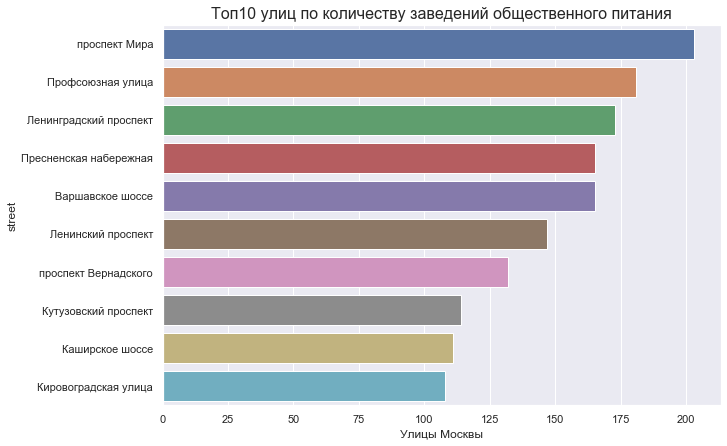

In [51]:
plt.figure(figsize=(10, 7))
sns.barplot(y='street', x='count', data=rest_data_streets[rest_data_streets.street.isin(top10_streets)])
plt.title('Топ10 улиц по количеству заведений общественного питания', fontdict={'fontsize': 16})
plt.xlabel('Количество заведений')
plt.xlabel('Улицы Москвы')
# plt.savefig('6.png', bbox_inches='tight');
plt.show()

`Проспект Мира` - одна из самых протяженных и оживленных улиц города Москвы. Неудивительно, что на ней находится самое большое количество заведений общественного питания.

Рассмотрим районы, где находятся данные улицы, на предмет количества заведений общепита также.

In [52]:
rest_data_upd[rest_data_upd.street.isin(top10_streets)]['district'].value_counts().head(10)

Пресненский район              165
район Чертаново Центральное     90
район Тропарёво-Никулино        88
Обручевский район               63
Мещанский район                 63
район Свиблово                  62
район Дорогомилово              61
район Аэропорт                  58
район Нагатино-Садовники        57
район Фили-Давыдково            53
Name: district, dtype: int64

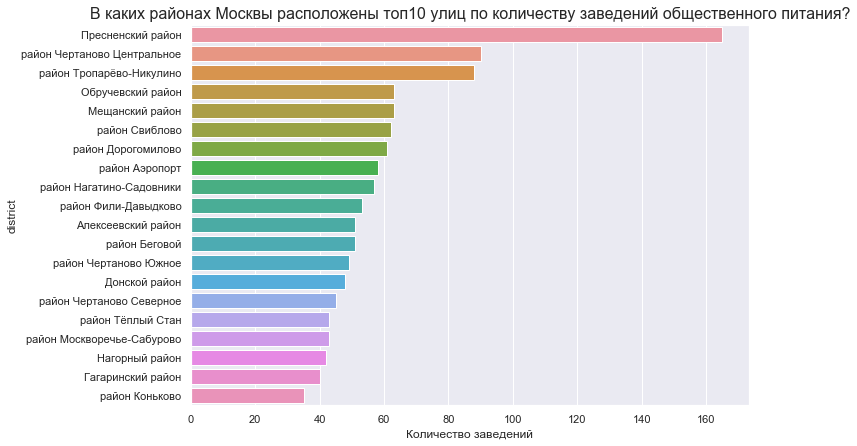

In [53]:
plt.figure(figsize=(10, 7))
sns.countplot(y='district', data=rest_data_upd[rest_data_upd.street.isin(
    top10_streets)], order=rest_data_upd[rest_data_upd.street.isin(top10_streets)]['district'].value_counts().head(20).index)
plt.title('В каких районах Москвы расположены топ10 улиц по количеству заведений общественного питания?', fontdict={'fontsize': 16})
plt.xlabel('Районы Москвы')
plt.xlabel('Количество заведений')
# plt.savefig('6-2.png', bbox_inches='tight');
plt.show()

`Пресненский район` — один из наиболее развитых с точки зрения социальной, коммерческой, транспортной инфраструктуры. Здесь находятся новостройки премиум-сегмента, огромное количество достопримечательностей, театры, деловой центр «Москва-Сити», и другие торговые центры. Данный район идеально подошел бы для премиум-сегмента. Но и аренда тут довольно дорогая, по всей видимости. Данный район, безусловно, лидирует по количеству заведений.

`район Чертаново Центральное` и `район Тропарёво-Никулино` - не самый центр, но развивающиеся районы, в которых активно развивается инфраструктура. Остальные районы, возможно, тоже, являются привлекательными для рестораторов ввиду усиленной застройки и высокой плотности населения.


### <a id="seven">Улицы Москвы с одним объектом общественного питания. </a> 

В датафрейме есть улицы с одним заведением общественного питания. Рассмотрим данные улицы.

In [54]:
print('На {} улицах находится лишь 1 объект общественного питания.'.format(
    len(rest_data_streets[rest_data_streets['count'] == 1]['street'])))
ratio_one_object = len(
    rest_data_streets[rest_data_streets['count'] == 1]['street'])/len(rest_data_streets['street']) 
print('Это {0:.2%} от общего количества улиц.'.format(ratio_one_object))

На 542 улицах находится лишь 1 объект общественного питания.
Это 28.85% от общего количества улиц.


In [55]:
rest_data_streets[rest_data_streets['count']== 1]['street'].head(10)

1337       4-я Кабельная улица
1338     4-я Гражданская улица
1339          Миусская площадь
1340      4-й Рощинский проезд
1341         Михневский проезд
1342           улица Брусилова
1343            Кучин переулок
1344    Мерзляковский переулок
1345              Мишина улица
1346          улица Недорубова
Name: street, dtype: object

Например, все эти 10 улиц протяженностью до 1 км максимум, неудивительно, что там находится максимум 1 заведение общественного питания. 

Рассмотрим районы, где находятся данные улицы.

In [56]:
# создадим список улиц, на которых расположено 1 заведение общепита
streets_with_one_restaurant = rest_data_streets[rest_data_streets['count']
                                                == 1]['street'].values
# выведем районы, где находятся эти улицы
rest_data_upd[rest_data_upd.street.isin(
    streets_with_one_restaurant)]['district'].value_counts().head(10)

район Хамовники        26
Таганский район        26
Пресненский район      20
Тверской район         19
район Марьина Роща     17
Басманный район        17
район Лефортово        12
Мещанский район        12
район Замоскворечье    12
район Сокольники       11
Name: district, dtype: int64

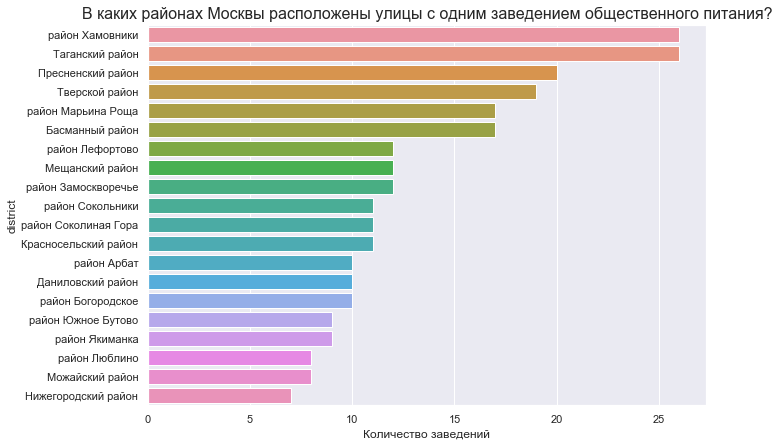

In [57]:
plt.figure(figsize=(10, 7))
sns.countplot(y='district', data=rest_data_upd[rest_data_upd.street.isin(
    streets_with_one_restaurant)], order=rest_data_upd[rest_data_upd.street.isin(streets_with_one_restaurant)]['district'].value_counts().head(20).index)
plt.title('В каких районах Москвы расположены улицы с одним заведением общественного питания?', fontdict={'fontsize': 16})
plt.xlabel('Районы Москвы')
plt.xlabel('Количество заведений')
# plt.savefig('7.png', bbox_inches='tight');
plt.show()

Первые пять районов выше - это Центральный Административный округ г. Москва. Скорее всего, из-за плотной застройки, тут часто появляются небольшие улицы, так сказать, ответвления от других. Тем не менее, утверждать, что данные районы непереспективны для ресторанного бизнеса - ошибка, даже наличие самого популярного Пресненского района на третьей позиции говорит об этом.

Улицы, на которых расположено лишь одно заведение общественного питания, либо просто коротки, либо находятся в зоне без социальной инфраструктуры и транспортной доступности.

### <a id="eight">Закономерности распределения количества посадочных мест для улиц с большим количеством объектов общественного питания.</a> 

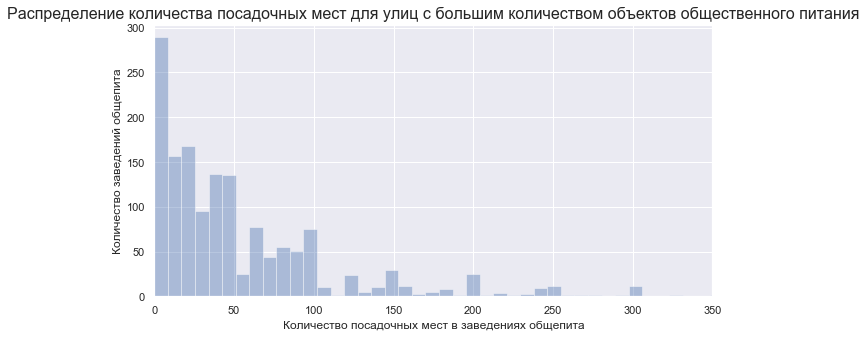

In [58]:
plt.figure(figsize=(10,5))
sns.distplot(rest_data_upd[rest_data_upd.street.isin(top10_streets)]['number'], kde=False, bins=200)
plt.title('Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания', fontdict={'fontsize': 16})
plt.xlabel('Количество посадочных мест в заведениях общепита')
plt.ylabel('Количество заведений общепита')
plt.xlim(0,350)
# plt.savefig('8.png', bbox_inches='tight');
plt.show()

Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания почти идентично с распределением количества посадочных мест для всех улиц.

Для заведений типично большое количество предприятий общественного питания с малым количеством посадочных мест и малое количество заведений с большой вместимостью - больше 100.

(-1, 300)

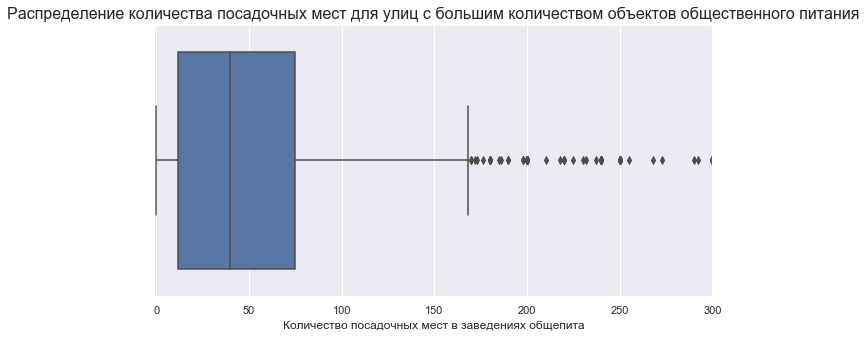

In [59]:
plt.figure(figsize=(10,5))
sns.boxplot(rest_data_upd[rest_data_upd.street.isin(top10_streets)]['number'])
plt.title('Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания', fontdict={'fontsize': 16})
plt.xlabel('Количество посадочных мест в заведениях общепита')
plt.xlim(-1,300)

При этом разброс значений по количеству посадочных мест на таких улицах шире - видимо, помимо кафе и фастфуда, здесь большое количество столовых. Многие люди предпочитают обедать там - это более доступно.

Text(0.5, 0.98, 'Распределение количества посадочных мест по типу объекта общественного питания на улицах с большим количеством заведений общепита')

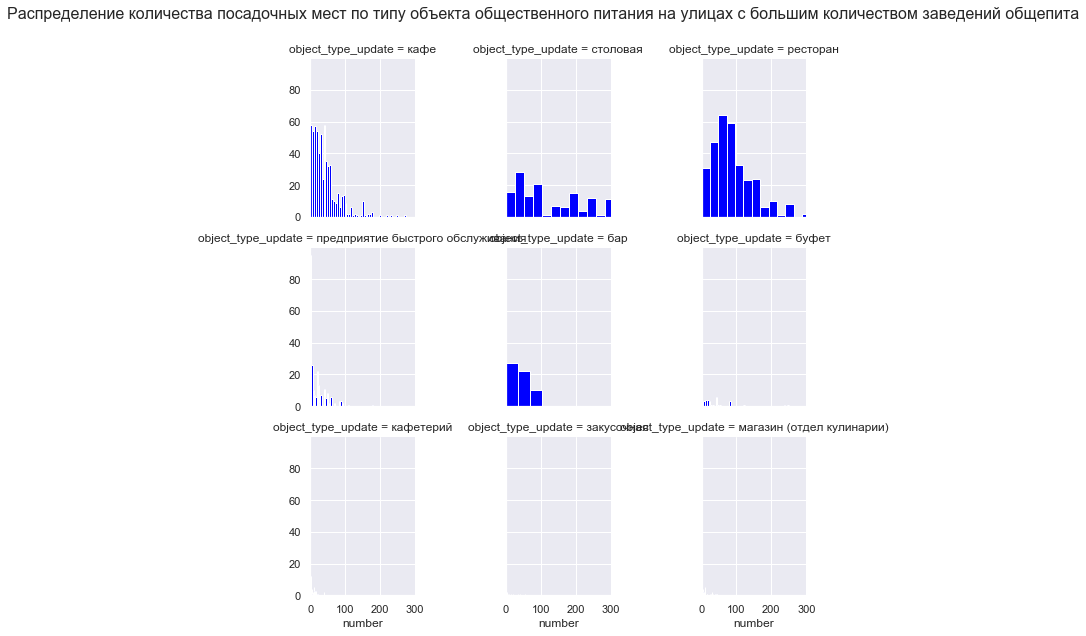

In [60]:
g = sns.FacetGrid(rest_data_upd[rest_data_upd.street.isin(top10_streets)], col='object_type_update',  col_wrap=3, margin_titles=True,
                  col_order=rest_data_upd['object_type_update'].value_counts().index)
g = g.map(plt.hist, 'number', bins=50, color='blue')
g.set(xlim=(0, 300))
g.fig.subplots_adjust(top=0.9) 
g.fig.suptitle('Распределение количества посадочных мест по типу объекта общественного питания на улицах с большим количеством заведений общепита', fontsize=16) 


На распределение количества посадочных мест повлияли не только столовые, но и рестораны с большой (больше 100) вместимостью. На этих улицах любят ходить в заведения, да побольше.

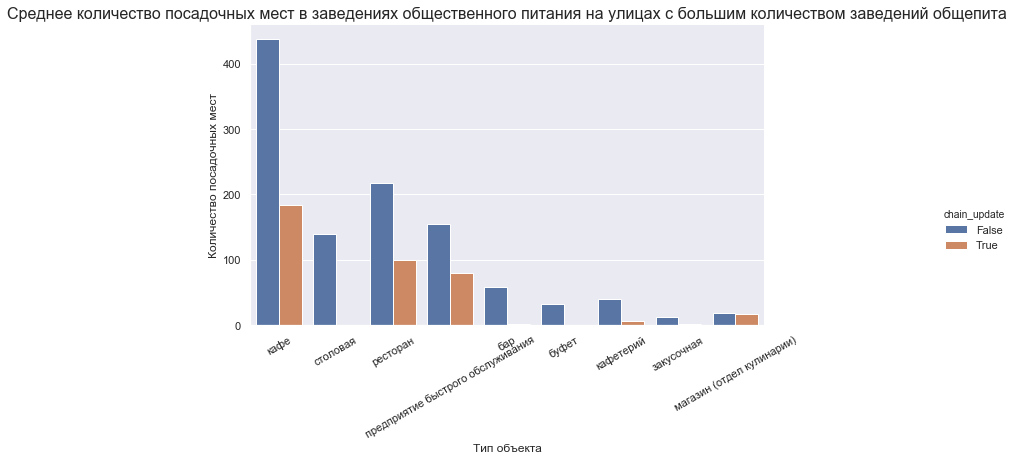

In [61]:
g = sns.catplot(x='object_type_update', kind='count', data=rest_data_upd[rest_data_upd.street.isin(top10_streets)],
                hue='chain_update', order=rest_data_upd['object_type_update'].value_counts().index)
g.fig.set_figwidth(10)
g.fig.set_figheight(5)
g.set_xticklabels(rotation=30)
plt.title('Среднее количество посадочных мест в заведениях общественного питания на улицах с большим количеством заведений общепита',
          fontdict={'fontsize': 16})
plt.xlabel('Тип объекта')
plt.ylabel('Количество посадочных мест')
#plt.savefig('8-2.png', bbox_inches='tight');
plt.show()

In [62]:
rest_data_upd[rest_data_upd.street.isin(top10_streets)]['number'].describe()

count    1499.000000
mean       58.133422
std        90.184899
min         0.000000
25%        12.000000
50%        40.000000
75%        75.000000
max      1700.000000
Name: number, dtype: float64

Не смотря на то, что по всему городу самое высокое среднее количество посадочных мест у столовых, ситуация тут иная - лидируют большие кафе, рестораны вмесщают в себя в среднем больше лбюдей, чем столовый, также столовые обгоняют предприятия быстрого обслуживания по среднему количеству посадочных мест.

## <a id="step3">Шаг 3. Выводы.</a>

Для открытия такого необычной для рынка общественного питания концепции обслуживания роботов следует рассмотреть в первую очередь Пресненский район города Москва ввиду большого количества предложений, а значит, и спроса со стороны жителей. Также этот район хорош тем, что представляет в большинстве своем премиум-сегмент недвижимости, деловой центр. Сюда более вероятнее будут ходить публика, которая может себе позволить оплатить чек выше среднего. Следуюет остерегаться размещения на улицах с одним типом общественного питания ввиду непопулярности и, порой, неузнаваемости улиц.

Можно рассмотреть и другие районы города Москвы, например, район Центральное Чертаново или Тропарёво-Никулино, но обращая внимания на топ 10 улиц по количеству заведений, ведь не во всем районе кипит насыщенная ресторанная жизнь, местами это обычные спальные районы.

Популярнее всего заведения типа `кафе`, ведь цены более демократичны. Несмотря на это, `ресторан` также хороший вариант, чтобы завлечь публику не повседневного спроса.

Количество посадочных мест можно выбрать исходя из среднего количества посадочных мест в ресторанах на улицах будущего расположения - 100-200 мест. Однако, лучшим вариантом было бы менее 100 мест - 50-70, чтобы качество оказываемых услуг было лучшим.

Развитие сети ресторанов, обслуживающих гостей с помощью роботов, возможно при создании узнаваемого бренда. Впервые люди будут посещать ресторан из любопытства, а в последующем - от признания качества сети.